# % DSP, Assignment 3, Anish Das $<$ jbjf314$>$ November 2020

## Part (a)

In [60]:
import scipy.signal as signal
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as image
import scipy.io.wavfile as wavfile
from scipy.fft import fft2, ifft2
from scipy.io.wavfile import read, write

In [2]:
# loading both the blurred image & the point-spread function
base_image = np.array(image.imread('stars-blurred.png'))
base_imageX, base_imageY = base_image.shape
psf_image = np.array(image.imread('stars-psf.png'))
psf_imageX, psf_imageY = psf_image.shape

In [8]:
# Applying window

#creating the windows along X and Y.
windowX = signal.windows.hann(base_imageX)
windowY = signal.windows.hann(base_imageY)

# building the final window using outer product and power.
window = np.outer(windowX, windowY)
window = np.power(window, 1/3.5)

base_windowed = np.multiply(base_image, window)

<img src="window_power.png">
Using a hann window raised to the power (1/3.5) so that we can capture more of the stars without introducing aliasing.

In [4]:
# Padding the images to be 512 by 512
base_padded = np.zeros((512, 512))
base_padded[:base_imageX, :base_imageY] = base_windowed
psf_padded = np.zeros((512, 512))
psf_padded[:psf_imageX, :psf_imageY] = psf_image

In [5]:
# Getting the 2D fourier transforms of the padded image and psf
base_fft = np.fft.fft2(base_padded)
psf_fft = fft2(psf_padded)

In [58]:
threshold = 5

adjusted_psf_fft = (np.abs(psf_fft) > threshold) * psf_fft
adjusted_psf_fft += (np.abs(psf_fft) <= threshold) * threshold

[]

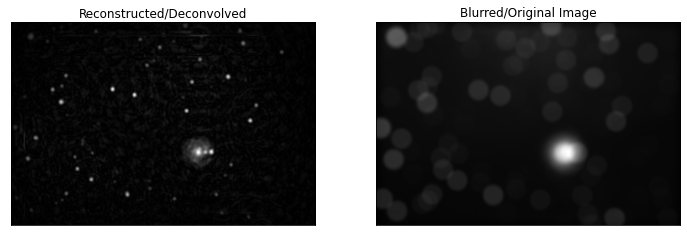

In [59]:
image_fft = base_fft / adjusted_psf_fft
image_reconstructed = ifft2(image_fft)
image_reconstructed = np.roll(a=image_reconstructed, shift=15, axis=0)
image_reconstructed = np.roll(a=image_reconstructed, shift=15, axis=1)
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].imshow(np.abs(image_reconstructed[:base_imageX, :base_imageY]), cmap='gray')
axs[1].imshow(base_image, cmap='gray')
axs[0].set_title('Reconstructed/Deconvolved')
axs[1].set_title('Blurred/Original Image')
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[1].set_xticks([])
axs[1].set_yticks([])

If we don't use the window on the base_image then we end up with some artifacts in the form of horizontal and vertical lines on the image. These artifiacts appear if we have a low threshold.

## Part (b.i)

In [84]:
floats_b = np.fromfile(file='iq-fm-96M-240k.dat', dtype=np.float32)
signal_b_i = floats_b[::2] + 1j*floats_b[1::2]
print(len(signal_b_i)/240000)

20.0


In [85]:
# signal_b_demodulated = np.unwrap(np.diff(np.angle(signal_b_i)))
# delta_t = 1.0 / 240000
# signal_b_demodulated = np.angle(signal_b_i[1:] / signal_b_i[:-1]) / delta_t

In [86]:
butter_1_b, butter_1_a = signal.butter(4, [16000], btype='lowpass', fs=120000)

signal_b_filtered = signal.filtfilt(butter_1_b, butter_1_a, signal_b_demodulated)

In [87]:
signal_b_resampled = signal_b_filtered[::5]

In [88]:
signal_b_abs = np.abs(signal_b_resampled)
output_signal = signal_b_abs/np.max(signal_b_abs)
write('output.wav', rate=48000, data=output_signal)